# Backcasting Demo Notebook

_Loren Champlin_

Adapted from _Adarsh Pyarelal_'s WM 12 Month Evaluation Notebook 

As always, we begin with imports, and print out the commit hash for a rendered
version of the notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pickle
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from delphi.visualization import visualize
import delphi.jupyter_tools as jt
import numpy as np
import pandas as pd
from delphi.db import engine
jt.print_commit_hash_message()
import random as rm
import sys
sys.path.insert(0,"../scripts/hackathon")
import evaluate_CAG as ec
import delphi.AnalysisGraph as AG
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.CRITICAL)

This notebook has been rendered with commit b'eae16bb4c6525904e819b273984245d992b284dc' of Delphi.


Here I will set random seeds

In [2]:
np.random.seed(87)
rm.seed(87)

In the cell below, we visualize the CAG.

Legend: 
- Red edge: overall inhibition, green edge: overall promotion
- Edge thickness corresponds roughly to the 'strength' of the influence.
- Edge opacity corresponds roughly to the number of evidence fragments 
  that support the causal relationship.

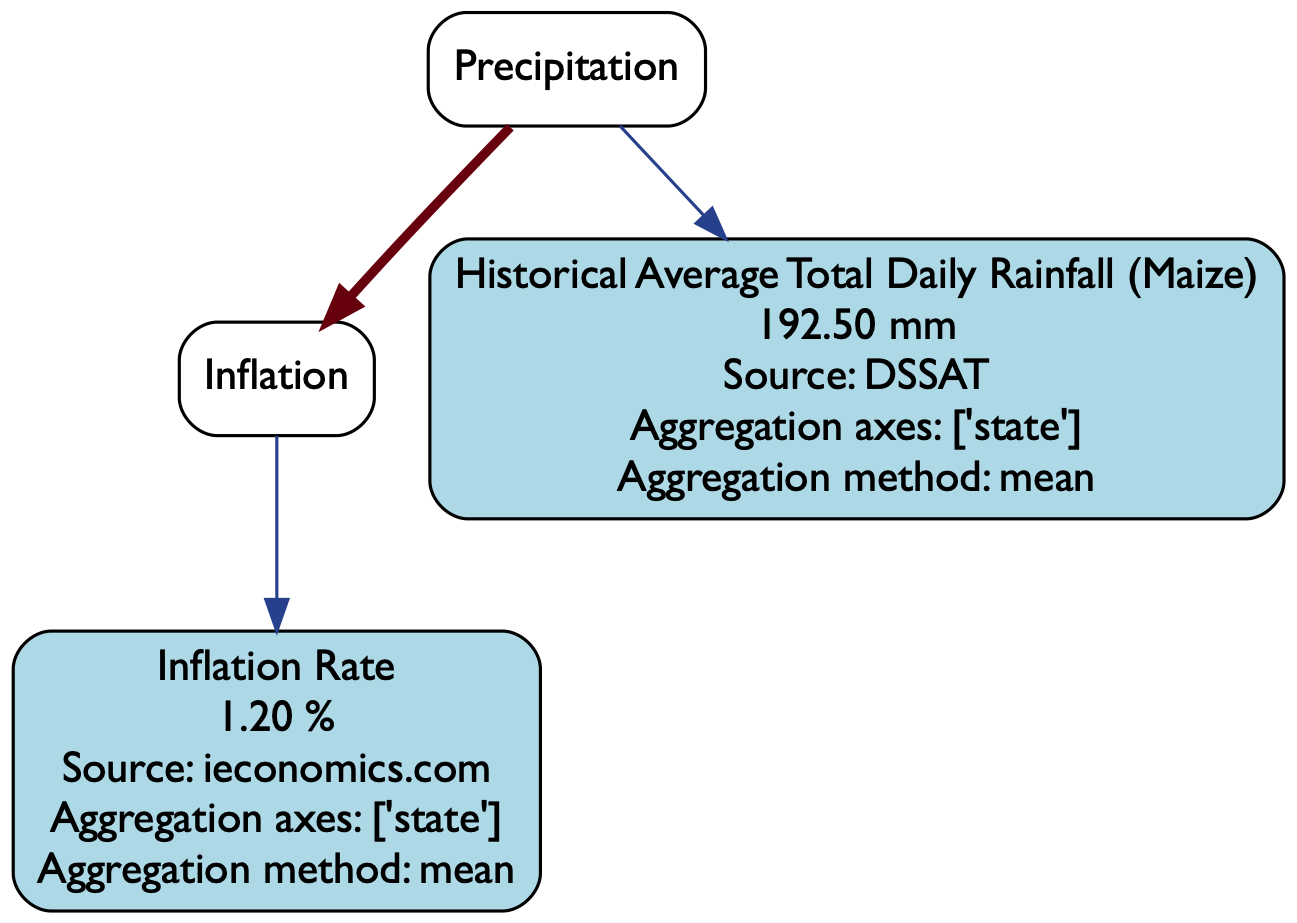

In [3]:
G = AG.from_text(
'Decreased Rainfall causes increased inflation rates', webservice='http://54.84.114.146:9000')

G.map_concepts_to_indicators()

G.set_indicator("UN/events/weather/precipitation", "Historical Average Total Daily Rainfall (Maize)", "DSSAT")

G.set_indicator("UN/entities/human/financial/economic/inflation", "Inflation Rate", "ieconomics.com")

G.res = 200
G.assemble_transition_model_from_gradable_adjectives()
G.sample_from_prior()
G.parameterize(year=2013,month=9)
visualize(G, indicators=True, indicator_values=True)

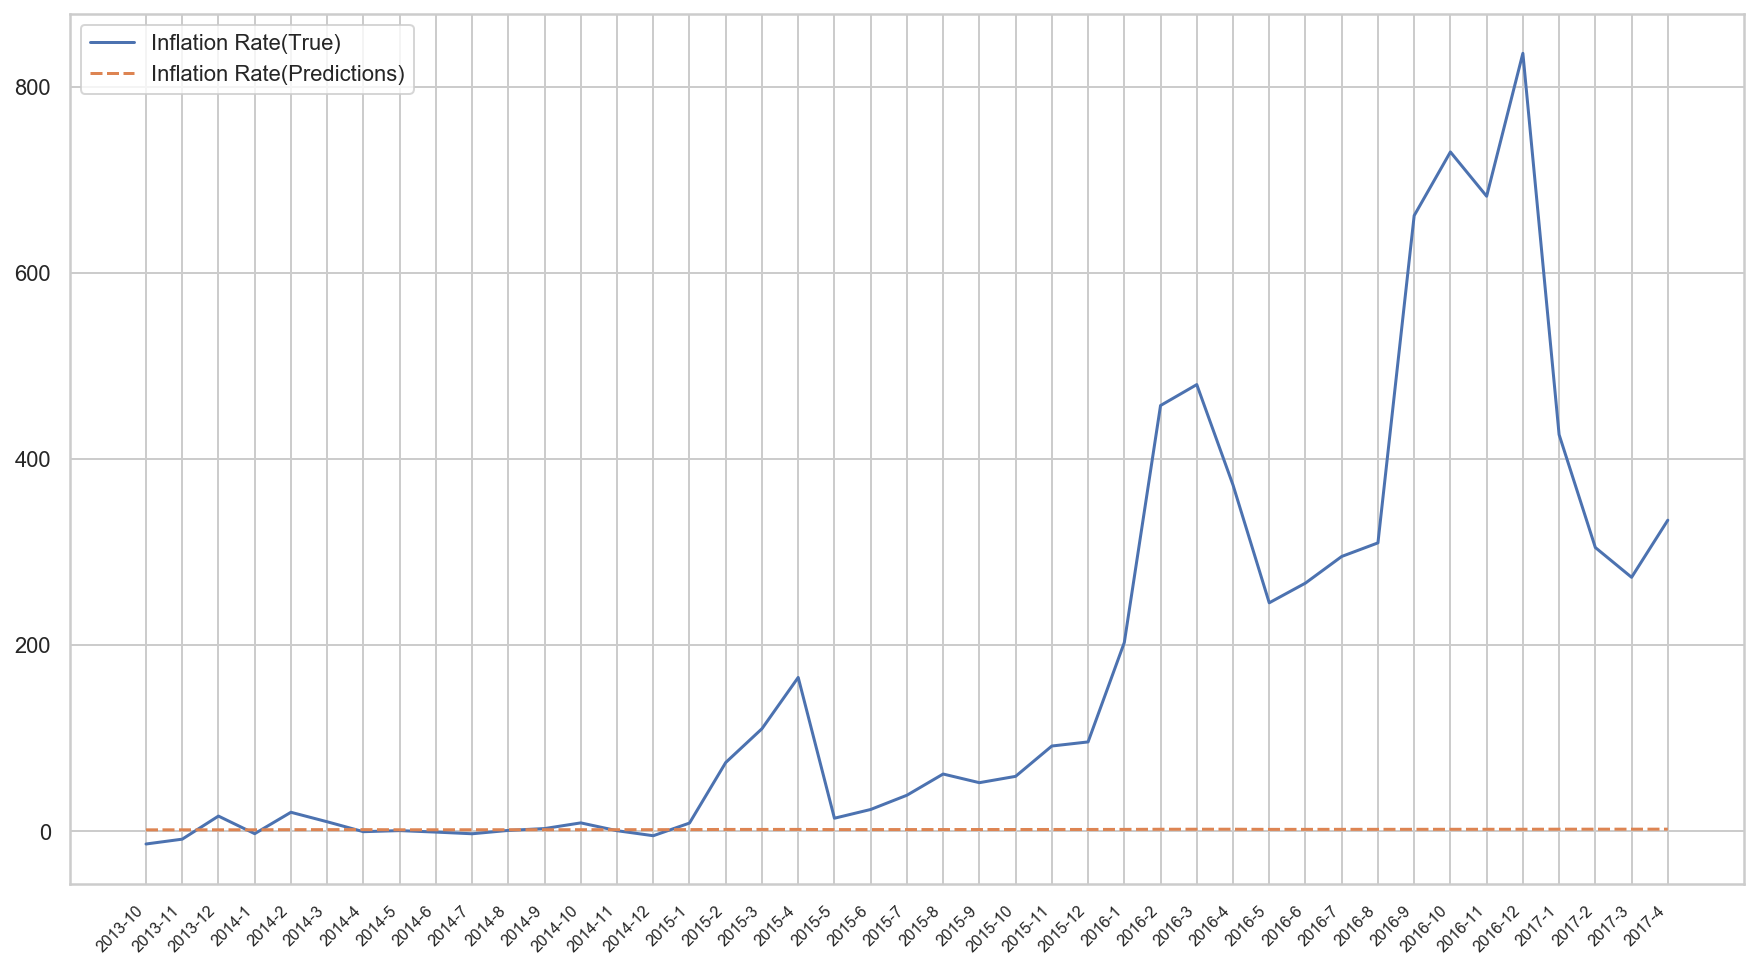

In [4]:
ec.evaluate_CAG(G,target_node="UN/entities/human/financial/economic/inflation",intervened_node="UN/events/weather/precipitation",start_year=2013,start_month=9,end_year=2017,end_month=4)


In [5]:
#node_name = "UN/events/weather/precipitation"
#ind = list(G.nodes(data=True)[node_name]['indicators'].keys())[0]
#df[df['Variable'] == ind]